# Lithology prediction

Firtsly, nesessary imports.

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import shutil
import dill
import datetime
import torch

sys.path.insert(0, os.path.join("..", "..", ".."))

from petroflow import WellDataset, WS
from petroflow.batchflow.models.torch import UNet
from petroflow.batchflow import DatasetIndex, FilesIndex, ImagesBatch, Pipeline, V, B, W, L, R, P

from utils import *

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="2"

Define constants that will be used at train and inference stages.

In [3]:
BATCH_SIZE = 8
N_CROPS = 4

DPCM = 25

CROPS_BATCH = BATCH_SIZE * N_CROPS

N_EPOCH = 250
LENGTH = 0.1
SHAPE = (3, int(DPCM * 100 * LENGTH), DPCM * 10)

FILTERS = ((2 ** np.arange(4)) * 4).tolist()

PATH = '/notebooks/data/september_dataset/core_photo/*/*'

Remove wells without `core_lithology`

In [4]:
ds = WellDataset(index=FilesIndex(path=PATH, dirs=True))
ds = filter_dataset(ds)

Get list of classes and construct mapping from classes to labels

In [5]:
classes = get_classes(ds)
reverse_mapping = dict(enumerate(classes))
mapping = {value: key for key, value in reverse_mapping.items()}

Preload all the data to make training process faster.

In [6]:
%%time

load_ppl = (ds.p
    .create_segments(src='samples', connected=True)
    .create_segments(src='core_lithology', connected=True)
    .drop_short_segments(LENGTH)
    .load_core(pixels_per_cm=DPCM)
    # .next_batch(8, n_epochs=1)
    .next_batch(len(ds), n_epochs=1)
)

ds = build_dataset(load_ppl)
ds.split(shuffle=42)

CPU times: user 28min, sys: 10min 35s, total: 38min 36s
Wall time: 4min 12s


In [7]:
def get_classes_distribution(*datasets, columns=None, classes=None):
    if columns is None:
        columns = range(len(datasets))
    distribution = []
    for ds, name in zip(datasets, columns):
        ppl = (ds.p
               .init_variable('df', default=[])
               .update(V('df', mode='e'), WS('core_lithology').ravel())
              )

        df = ppl.run(len(ds), n_epochs=1).v('df')

        df = (pd.concat(df)
              .reset_index(drop=False)
              .groupby(['FORMATION', 'GRAIN'])
              .apply(lambda x: (x.DEPTH_TO - x.DEPTH_FROM).sum()))

        df_index = df.index.to_frame().apply(concat, axis=1)
        stat = pd.concat([df_index, df], axis=1, sort=True)
        stat.columns = ['CLASS', name]
        stat = stat.set_index('CLASS')
        if classes is not None:
            for item in set(classes) - set(stat.index):
                stat.loc[item] = 0
        distribution.append(stat)
    df = pd.concat(distribution, axis=1, sort=True).fillna(0)
    for name in columns:
        df[name+'_ratio'] = df[name] / df[name].sum()
    return df

In [8]:
distribution = get_classes_distribution(ds.train, ds.test, columns=['TRAIN', 'TEST'], classes=classes)
weights = distribution['TRAIN'].values
weights = (1 / weights)
weights[weights == np.inf] = weights[weights != np.inf].max()
weights = weights / sum(weights) * len(weights)

## Train model

In [9]:
crop_template = (Pipeline()
       .add_namespace(np)
       .copy()
       .random_crop(length=LENGTH, n_crops=N_CROPS)
       .update(WS('core_lithology')['CLASS'],
               WS('core_lithology')[['FORMATION', 'GRAIN']].apply(concat, axis=1).ravel())
       .create_mask(src='core_lithology', column='CLASS', mapping=mapping, mode='core')
       .update(B('core'), WS('core_dl').ravel())
       .update(B('masks'), WS('mask').ravel())
       .array(B('core'), save_to=B('core'))
       .array(B('masks'), save_to=B('masks'))
       .reshape(B('masks'), (-1, 1, SHAPE[1]), save_to=B('masks'))
)

In [10]:
augmentation_template = (
    Pipeline()
    .update(B().index, L(DatasetIndex)(L(len)(B('core'))))
    .rebatch(CROPS_BATCH, batch_class=ImagesBatch, components=('core', 'masks'))
    .add_namespace(np)
    .to_pil(src='core', dst='core')
    .scale(src='core', dst='core', preserve_shape=True, factor=P(R('uniform', low=1, high=1.5)))
    .cutout(shape=P(R('randint', low=0, high=DPCM * 10)),
            origin=P(R('uniform', size=2)), color=0,
            src='core', dst='core', p=0.5)
    .multiply(src='core', dst='core', multiplier=P(R('uniform', low=0.7, high=1.2)))
    .to_array(src='core', dst='core', dtype='float32')
    .transpose(B('core'), axes=(0, 3, 1, 2), save_to=B('core'))
)

In [11]:
model_config = {
    "body/encoder/num_stages": len(FILTERS[:-1]),
    'body/encoder/blocks/filters': FILTERS[:-1],
    "body/decoder/blocks/filters": FILTERS[-2::-1],
    "initial_block/inputs": "inputs",
    "inputs/inputs/shape": SHAPE,
    'inputs/masks/shape': (len(mapping), 1, SHAPE[1]),
    "head": dict(layout="c",
                 kernel_size=(SHAPE[2], 1), padding='valid', conv=dict(bias=True)),
    "loss": 'ce',# dict(weight=torch.tensor(weights, dtype=torch.float32).to('cuda:0'))),
    "optimizer": {"name": "Adam", "lr": 0.01},
    "output": 'proba',
    "device": 'cuda:0'
}
        
train_template = (Pipeline()
    .init_variable('loss_history', default=[])
    .init_model('dynamic', UNet, 'model', model_config)
    .train_model('model', B('core').astype('float32'), B('masks'),
                 fetches='loss', save_to=V('loss_history', mode='a'))
)

train_ppl = (crop_template + augmentation_template + train_template) << ds.train

In [12]:
train_ppl.run(BATCH_SIZE, n_epochs=N_EPOCH, bar=True, bar_desc=W(V('loss_history')[-1]))

  0%|          | 0/5094 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3509: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

../../../petroflow/batchflow/batchflow/batch_image.py:962: UserWarning:

Note that some info might be lost during `multiply` transformation since PIL.image stores data as `np.uint8`. To suppress this warning, use `preserve_type=True` or consider using `to_array` action before multiplication.

2.2021582: 100%|██████████| 5094/5094 [1:31:14<00:00,  1.07s/it]


Dump results

In [13]:
SAVE_TO = './models/unet_' + str(datetime.datetime.now()).replace(' ', '_')
dump_results(train_ppl, SAVE_TO)

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning:

Couldn't retrieve source code for container of type DefaultBlock. It won't be checked for correctness upon loading.

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning:

Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning:

Couldn't retrieve source code for container of type EncoderModule. It won't be checked for correctness upon loading.

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning:

Couldn't retrieve source code for container of type ModuleList. It won't be checked for correctness upon loading.

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning:

Couldn't retrieve source code for container of type ConvBlock. It won't be checked for correctness upon loading.

/usr/local/lib/p

In [14]:
model_path = get_last_model_path('./models/unet_*')
print(model_path)

./models/unet_2020-01-22_09:56:06.001798


Load loss

In [15]:
with open(os.path.join(model_path, 'loss.pkl'), 'rb') as f:
    loss = dill.load(f)

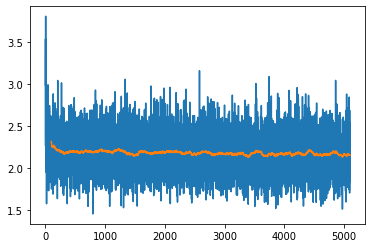

In [16]:
import pandas as pd
plt.plot(loss)
plt.plot(pd.Series(loss).rolling(window=100).mean())

## Inference

In [17]:
def test_template(length, random_crop=False, step=None, n_crops=None):
    step = step or length
    n_crops = n_crops or 4

    if random_crop:
        ppl = Pipeline().random_crop(length=length, n_crops=n_crops)
    else:
        ppl = Pipeline().crop(length=length, step=step)

    ppl = ppl + (Pipeline()
        .add_namespace(np)
        .copy()
        .add_components(('core', 'masks'))
        .update(WS('core_lithology')['CLASS'], WS('core_lithology')[['FORMATION', 'GRAIN']].apply(concat, axis=1).ravel())
        .create_mask(src='core_lithology', column='CLASS', mapping=mapping, mode='core').update(B('core'), WS('core_dl').ravel())
        .update(B('masks'), WS('mask').ravel())
        .array(B('core'), save_to=B('core'))
        .array(B('masks'), save_to=B('masks'))
        .transpose(B('core'), axes=(0, 3, 1, 2), save_to=B('core'))
        .reshape(B('masks'), (-1, 1, DPCM * 10), save_to=B('masks'))
        .update(B().index, L(DatasetIndex)(B('core').shape[0]))
        .rebatch(32, components=('core', 'masks'), batch_class=ImagesBatch)
        .init_variable('metrics')
        .add_namespace(np)
        .init_model('dynamic', UNet, 'model', config={
                        'device': 'gpu:0', 'load/path': os.path.join(model_path, 'unet.torch')
                    })
        .predict_model('model', B('core').astype('float32'), fetches='proba', save_to=B('proba'))
        .gather_metrics('classification', targets=B('masks').reshape(-1),
                        predictions=B('proba').argmax(1).reshape(-1),
                        fmt='labels', num_classes=len(mapping), save_to=V('metrics', mode='u'))
    )
    return ppl

test_ppl = test_template(LENGTH, random_crop=False) << ds.test

In [18]:
test_ppl.run(5, bar=True)

dump_metrics(test_ppl, os.path.join(model_path, 'metrics.pkl'))

675it [1:32:00,  8.18s/it]                    


In [19]:
def get_last_model_path(path, index=-1):
    return sorted(glob.glob(path))[index]

model_path = get_last_model_path('./models/unet_*', -2)

In [20]:
with open(os.path.join(model_path, 'metrics.pkl'), 'rb') as f:
    metrics = dill.load(f)

F1-scores

In [21]:
for i, item in enumerate(metrics.evaluate('f1_score', agg='mean', multiclass=None)):
    print(reverse_mapping[i], item)

алевролит UNKNOWN 0.0
алевролит крупно-мелкозернистый 0.0
алевролит крупнозернистый 0.0
алевролит мелкозернистый 0.0
алевролит разнозернистый 0.0
аргиллит UNKNOWN 0.0
глина UNKNOWN 0.0
доломит UNKNOWN 0.0
известняк UNKNOWN 0.0
песчаник UNKNOWN 0.0
песчаник крупнозернистый 1.0
песчаник мелкозернистый 0.0
песчаник разнозернистый 0.0
песчаник средне-мелкозернистый 0.0
песчаник среднезернистый 0.04607168718320058
песчаник тонко-мелкозернистый 0.0
песчаник тонкозернистый 0.0
уголь UNKNOWN 0.0


Some examples

In [22]:
batch = (test_template(LENGTH, random_crop=True) << ds.test).next_batch(1)

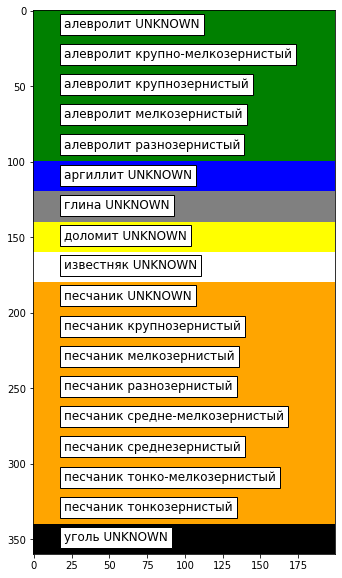

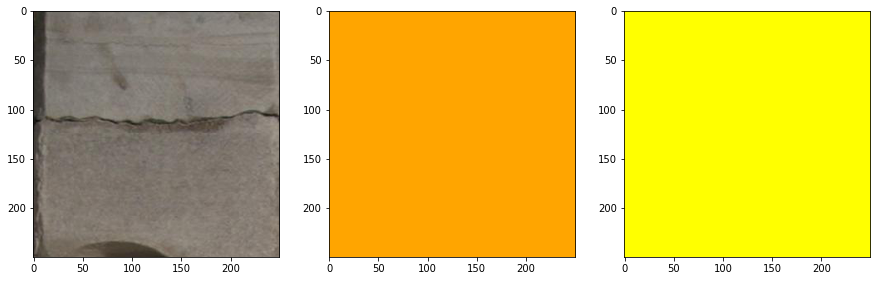

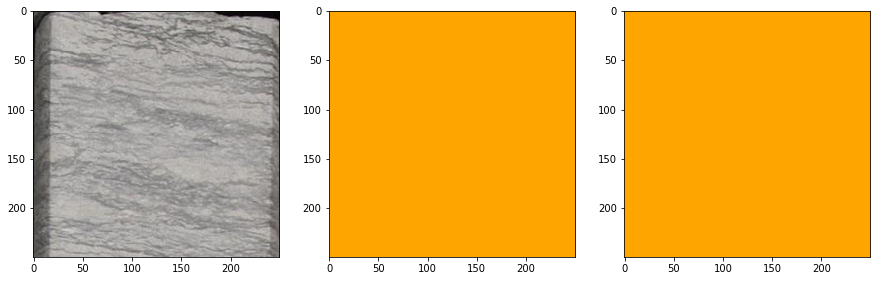

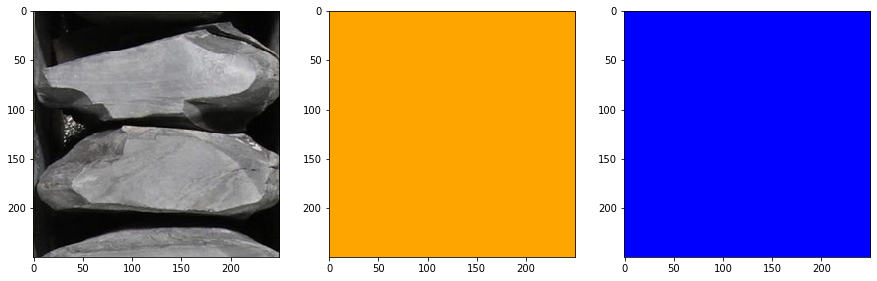

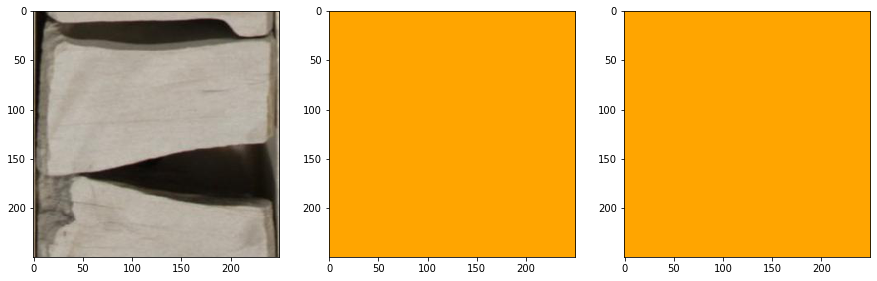

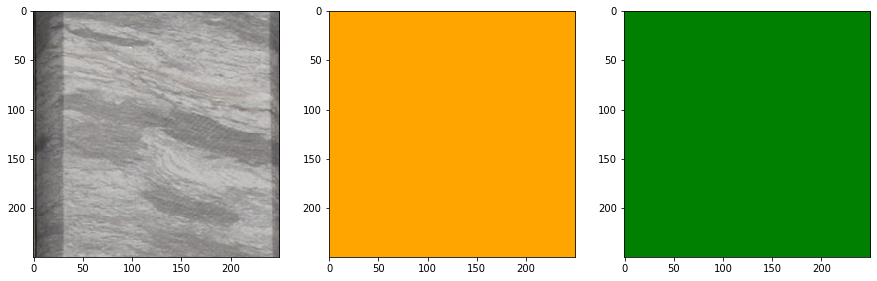

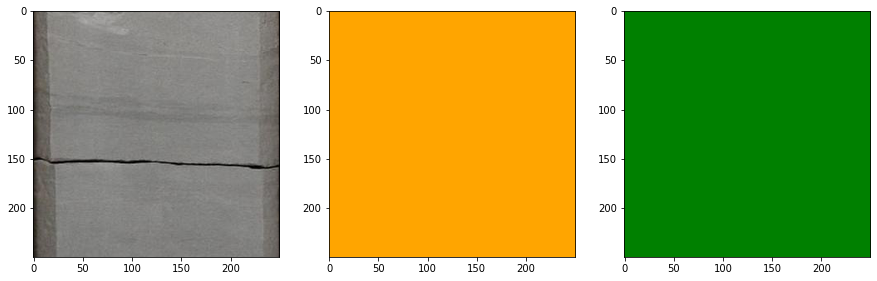

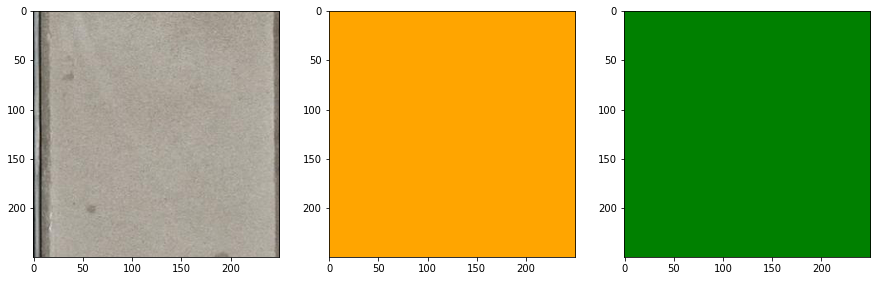

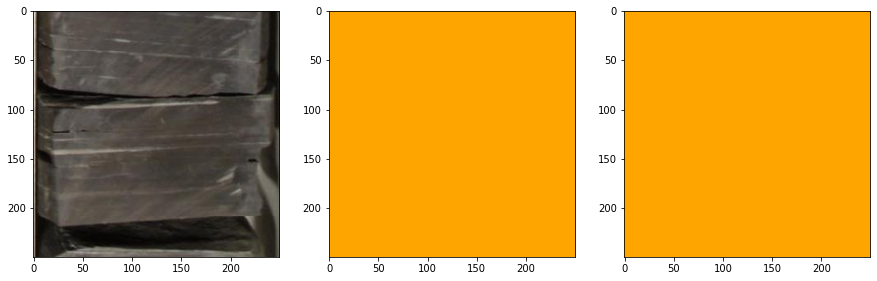

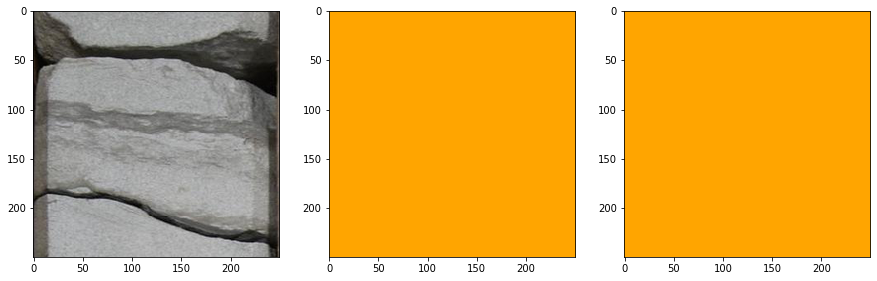

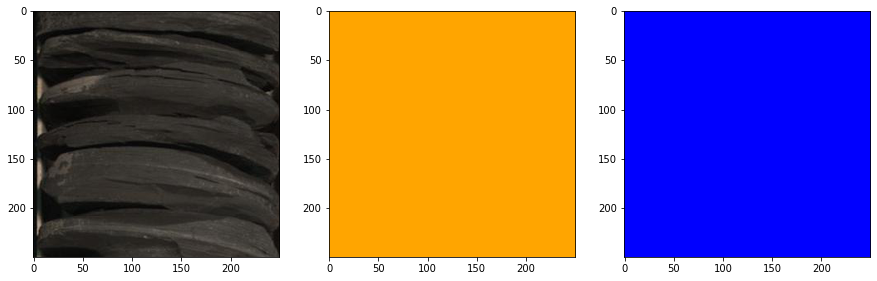

In [23]:
plot_examples(batch, reverse_mapping)